# Setup

In [1]:
# Core libraries
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import mygene
import scipy.sparse as sp
from scipy.stats import spearmanr
from adjustText import adjust_text
import seaborn as sb

mg = mygene.MyGeneInfo()
sb.set_style("white")

/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/anndata/utils.py:429: Futur

# Read files

In [2]:
liver = ad.read_h5ad('/home/yotamyan/data/liver/seperate_endo_model_cells.h5ad')
heart = ad.read_h5ad('/home/yotamyan/data/heart/seperate_endo_model_cells.h5ad')

# Convert ensemble IDs to gene symbols

In [3]:
# Extract Ensembl IDs from heart.var_names
ensembl_ids_heart = [gene for gene in heart.var_names if gene.startswith('ENSG')]
ensembl_ids_liver = [gene for gene in liver.var_names if gene.startswith('ENSG')]

print(f"Found {len(ensembl_ids_heart)} Ensembl IDs")
print(f"Found {len(ensembl_ids_liver)} Ensembl IDs")

# Strip version suffixes
ensembl_ids_heart_clean = [gene.split('.')[0] for gene in ensembl_ids_heart]
ensembl_ids_liver_clean = [gene.split('.')[0] for gene in ensembl_ids_liver]

# Query MyGene
query_result_heart = mg.querymany(
    ensembl_ids_heart_clean,
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

query_result_liver = mg.querymany(
    ensembl_ids_liver_clean,
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

# Build mapping
ensembl_to_symbol_heart = {
    entry['query']: entry.get('symbol', entry['query'])
    for entry in query_result_heart
}

ensembl_to_symbol_liver = {
    entry['query']: entry.get('symbol', entry['query'])
    for entry in query_result_liver
}

# Replace var_names
new_varnames_heart = [
    ensembl_to_symbol_heart.get(gene.split('.')[0], gene)
    if gene.startswith('ENSG') else gene
    for gene in heart.var_names
]
heart.var_names = new_varnames_heart

new_varnames_liver = [
    ensembl_to_symbol_liver.get(gene.split('.')[0], gene)
    if gene.startswith('ENSG') else gene
    for gene in liver.var_names
]
liver.var_names = new_varnames_liver

# Remove _ENSG suffixes
heart.var_names = [name.split('_')[0] if '_' in name else name for name in heart.var_names]
liver.var_names = [name.split('_')[0] if '_' in name else name for name in liver.var_names]

# Check result
print(heart.var_names[:10])
print(liver.var_names[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 7792 Ensembl IDs
Found 0 Ensembl IDs


18 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
621 input query terms found no hit:	['ENSG00000238009', 'ENSG00000230699', 'ENSG00000241180', 'ENSG00000236948', 'ENSG00000226849', 'ENS
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'OR4F29',
       'ENSG00000235146'],
      dtype='object')
Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1'],
      dtype='object')


# Check if F8 is present in both datasets

In [4]:
print('F8' in heart.var_names and 'F8' in liver.var_names)

True


# Normalize and log-transform

In [5]:
sc.pp.normalize_total(liver, target_sum=1e4)
sc.pp.log1p(liver)

sc.pp.normalize_total(heart, target_sum=1e4)
sc.pp.log1p(heart)

# Find highly expressed genes

/home/ofirr/miniforge3/envs/amosbase8/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Liver mean range: 0.0000–4.7215
Heart mean range: 0.0000–2.7201
Liver dropout range: 0.00–1.00
Heart dropout range: 0.08–1.00
Liver mean pass: 11660
Heart mean pass: 10999
Liver dropout pass: 5370
Heart dropout pass: 2836


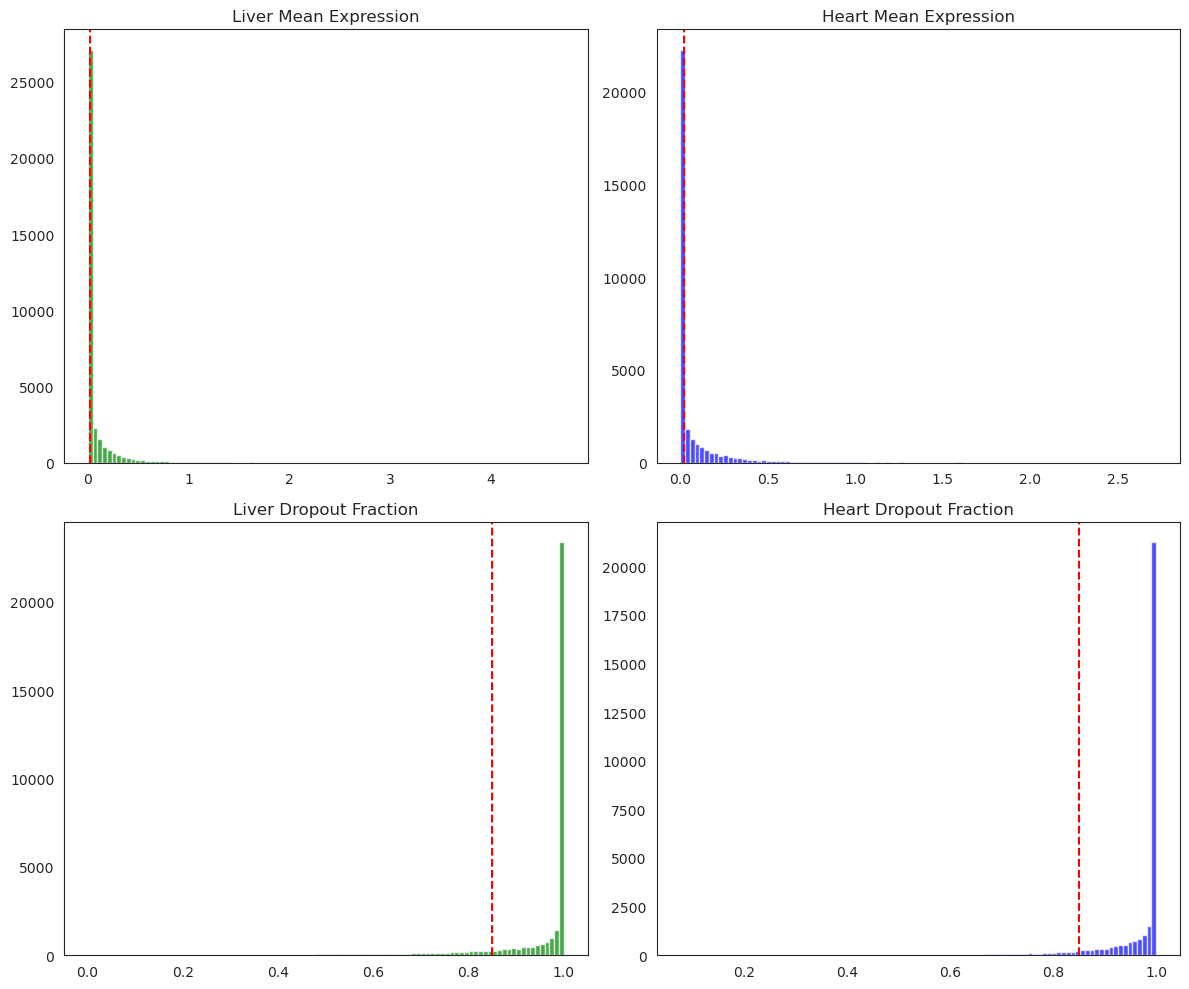

In [6]:
# MEASURE STATS ONLY
mean_threshold = 0.02
dropout_threshold = 0.85

mean_expr_liver = liver.X.mean(axis=0).A1 if sp.issparse(liver.X) else liver.X.mean(axis=0)
mean_expr_heart = heart.X.mean(axis=0).A1 if sp.issparse(heart.X) else heart.X.mean(axis=0)

dropout_liver = (liver.X == 0).mean(axis=0).A1 if sp.issparse(liver.X) else (liver.X == 0).mean(axis=0)
dropout_heart = (heart.X == 0).mean(axis=0).A1 if sp.issparse(heart.X) else (heart.X == 0).mean(axis=0)

print(f"Liver mean range: {mean_expr_liver.min():.4f}–{mean_expr_liver.max():.4f}")
print(f"Heart mean range: {mean_expr_heart.min():.4f}–{mean_expr_heart.max():.4f}")
print(f"Liver dropout range: {dropout_liver.min():.2f}–{dropout_liver.max():.2f}")
print(f"Heart dropout range: {dropout_heart.min():.2f}–{dropout_heart.max():.2f}")

# Report number that *would* pass
print(f"Liver mean pass: {(mean_expr_liver > mean_threshold).sum()}")
print(f"Heart mean pass: {(mean_expr_heart > mean_threshold).sum()}")
print(f"Liver dropout pass: {(dropout_liver < dropout_threshold).sum()}")
print(f"Heart dropout pass: {(dropout_heart < dropout_threshold).sum()}")

# PLOT
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0,0].hist(mean_expr_liver, bins=100, color='green', alpha=0.7)
axs[0,0].axvline(mean_threshold, color='red', linestyle='--')
axs[0,0].set_title('Liver Mean Expression')

axs[0,1].hist(mean_expr_heart, bins=100, color='blue', alpha=0.7)
axs[0,1].axvline(mean_threshold, color='red', linestyle='--')
axs[0,1].set_title('Heart Mean Expression')

axs[1,0].hist(dropout_liver, bins=100, color='green', alpha=0.7)
axs[1,0].axvline(dropout_threshold, color='red', linestyle='--')
axs[1,0].set_title('Liver Dropout Fraction')

axs[1,1].hist(dropout_heart, bins=100, color='blue', alpha=0.7)
axs[1,1].axvline(dropout_threshold, color='red', linestyle='--')
axs[1,1].set_title('Heart Dropout Fraction')

plt.tight_layout()
plt.show()

# Filter

In [7]:
# APPLY FILTERING
liver_mean_mask = mean_expr_liver > mean_threshold
heart_mean_mask = mean_expr_heart > mean_threshold

liver_dropout_mask = dropout_liver < dropout_threshold
heart_dropout_mask = dropout_heart < dropout_threshold

liver_final_mask = liver_mean_mask & liver_dropout_mask
heart_final_mask = heart_mean_mask & heart_dropout_mask

print(f"Liver genes retained: {liver_final_mask.sum()}")
print(f"Heart genes retained: {heart_final_mask.sum()}")

# Filter AnnData
liver = liver[:, liver_final_mask]
heart = heart[:, heart_final_mask]

Liver genes retained: 5370
Heart genes retained: 2836


In [8]:
print(f"Filtered liver shape: {liver.shape}")
print(f"Filtered heart shape: {heart.shape}")

# Re-extract matrices after filtering
liver_X = liver.X.toarray()
heart_X = heart.X.toarray()

print(f"Filtered liver_X shape: {liver_X.shape}")
print(f"Filtered heart_X shape: {heart_X.shape}")

Filtered liver shape: (22991, 5370)
Filtered heart shape: (56747, 2836)
Filtered liver_X shape: (22991, 5370)
Filtered heart_X shape: (56747, 2836)


# Spearman correlation

In [9]:
# Compute Spearman correlations
liver_df = pd.DataFrame(liver_X, columns=liver.var_names)
heart_df = pd.DataFrame(heart_X, columns=heart.var_names)

# Compute Spearman correlation with F8
liver_spearman = liver_df.corrwith(liver_df['F8'], method='spearman')
heart_spearman = heart_df.corrwith(heart_df['F8'], method='spearman')

print(liver_spearman.shape)
print(heart_spearman.shape)

(5370,)
(2836,)


# Remove NaNs

In [10]:
# Check how many NaNs
print(np.isnan(liver_spearman).sum())
print(np.isnan(heart_spearman).sum())

# Mask and filter
liver_valid_mask = ~np.isnan(liver_spearman)
heart_valid_mask = ~np.isnan(heart_spearman)

liver_spearman = liver_spearman[liver_valid_mask]
heart_spearman = heart_spearman[heart_valid_mask]

liver_genes = liver.var_names[liver_valid_mask]
heart_genes = heart.var_names[heart_valid_mask]

0
0


# Find shared genes

In [11]:
liver_gene_set = set(liver_genes)
heart_gene_set = set(heart_genes)

shared_genes = liver_gene_set & heart_gene_set
print(f"Number of shared genes: {len(shared_genes)}")

Number of shared genes: 2715


In [12]:
shared_genes_list = sorted(shared_genes)

# Index lookup
liver_gene_to_index = {gene: i for i, gene in enumerate(liver_genes)}
heart_gene_to_index = {gene: i for i, gene in enumerate(heart_genes)}

liver_indices = [liver_gene_to_index[gene] for gene in shared_genes_list]
heart_indices = [heart_gene_to_index[gene] for gene in shared_genes_list]

liver_corr_shared = liver_spearman[liver_indices]
heart_corr_shared = heart_spearman[heart_indices]

print(liver_corr_shared.shape)
print(heart_corr_shared.shape)

(2715,)
(2715,)


/tmp/ipykernel_1344346/3456369544.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liver_corr_shared = liver_spearman[liver_indices]
/tmp/ipykernel_1344346/3456369544.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  heart_corr_shared = heart_spearman[heart_indices]


# Find liver-specific genes correlated to F8

In [13]:
# Set thresholds
liver_threshold = 0.2
heart_threshold = 0.05

# Boolean mask
liver_specific_mask = (liver_corr_shared > liver_threshold) & (heart_corr_shared < heart_threshold)

# Gene list
liver_specific_genes = [shared_genes_list[i] for i, flag in enumerate(liver_specific_mask) if flag]

print(f"Number of liver-specific F8 correlated genes: {len(liver_specific_genes)}")
print(liver_specific_genes[:10])

Number of liver-specific F8 correlated genes: 38
['AKAP12', 'C11orf96', 'C1QTNF1', 'C1orf21', 'CRIM1', 'CTNNAL1', 'CTSD', 'DLC1', 'DUSP6', 'FAM167B']


# Correlation plot

/tmp/ipykernel_1344346/62945162.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liver_specific_heart_corr = [heart_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]
/tmp/ipykernel_1344346/62945162.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liver_specific_liver_corr = [liver_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]


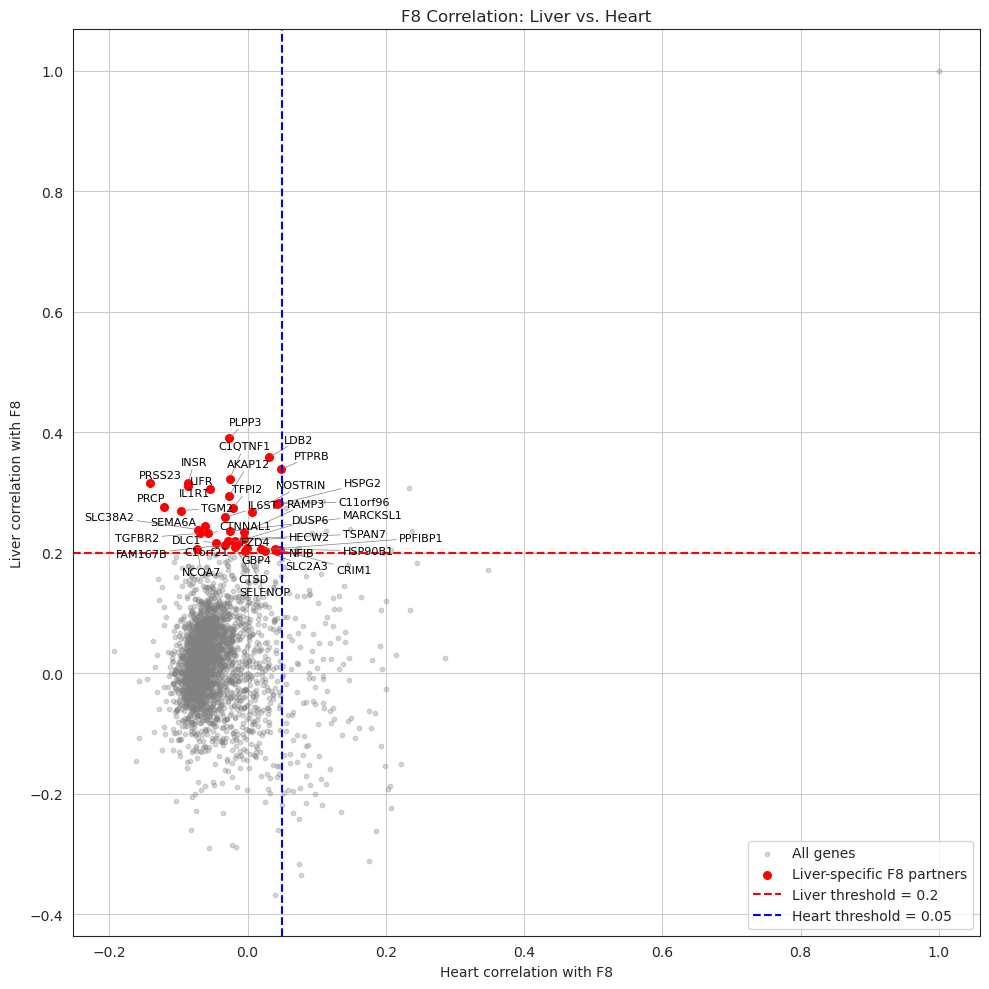

In [14]:
plt.figure(figsize=(10, 10))

# Plot all genes
plt.scatter(
    heart_corr_shared,
    liver_corr_shared,
    s=10,
    alpha=0.3,
    color='gray',
    label='All genes'
)

# Plot liver-specific genes
liver_specific_heart_corr = [heart_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]
liver_specific_liver_corr = [liver_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]

plt.scatter(
    liver_specific_heart_corr,
    liver_specific_liver_corr,
    color='red',
    s=30,
    label='Liver-specific F8 partners'
)

# Threshold lines
plt.axhline(y=liver_threshold, color='red', linestyle='--', label=f'Liver threshold = {liver_threshold}')
plt.axvline(x=heart_threshold, color='blue', linestyle='--', label=f'Heart threshold = {heart_threshold}')

# Add labels with adjustText to avoid overlap
texts = []
for x, y, gene in zip(liver_specific_heart_corr, liver_specific_liver_corr, liver_specific_genes):
    texts.append(plt.text(x, y, gene, fontsize=8, color='black'))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final plot formatting
plt.xlabel('Heart correlation with F8')
plt.ylabel('Liver correlation with F8')
plt.title('F8 Correlation: Liver vs. Heart')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Heat map

/tmp/ipykernel_1344346/1398487661.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liver_spec_liver_corr = [liver_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]
/tmp/ipykernel_1344346/1398487661.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  liver_spec_heart_corr = [heart_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]


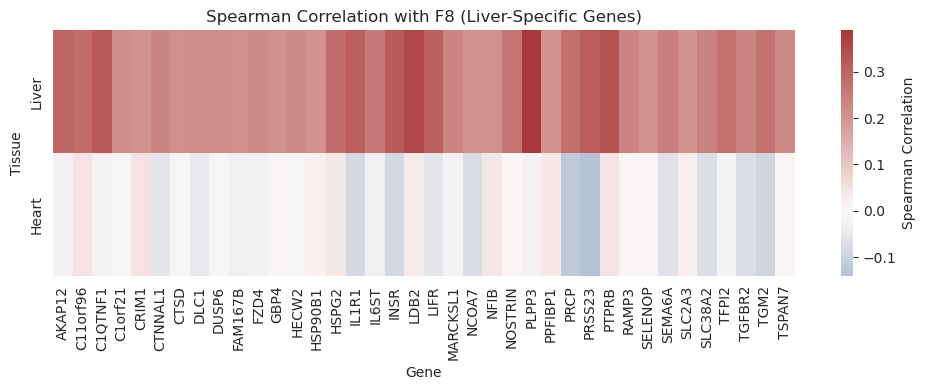

In [15]:
import seaborn as sns

# Extract only the liver-specific genes from shared data
liver_spec_liver_corr = [liver_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]
liver_spec_heart_corr = [heart_corr_shared[i] for i, flag in enumerate(liver_specific_mask) if flag]

# Build DataFrame for heatmap
heatmap_df = pd.DataFrame({
    'Liver': liver_spec_liver_corr,
    'Heart': liver_spec_heart_corr
}, index=liver_specific_genes).T  # Transpose so tissues are rows

plt.figure(figsize=(max(10, len(liver_specific_genes)//5), 4))
sns.heatmap(heatmap_df, cmap='vlag', center=0, cbar_kws={'label': 'Spearman Correlation'})
plt.title('Spearman Correlation with F8 (Liver-Specific Genes)')
plt.xlabel('Gene')
plt.ylabel('Tissue')
plt.tight_layout()
plt.show()